# Facial Recognition Pipeline

Predict the labels for image data with a popular dataset
the Labeled Faces in the Wild dataset from the scikit-learn library. The dataset is called
the Olivetti Face dataset and it comprises pictures of famous people's faces, with
appropriate labels

In [6]:
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from time import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [7]:
#get faces and resize
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [10]:
#1288 images height 50 pixels, width 37 pixels
n_samples,h,w = lfw_people.images.shape
n_samples,h,w

(1288, 50, 37)

In [11]:
X = lfw_people.data
y = lfw_people.target
n_features = X.shape[1]

In [13]:
#50*37
n_features

1850

In [14]:
X.shape

(1288, 1850)

## Explore the data


'Hugo Chavez'

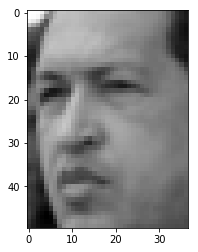

In [16]:
plt.imshow(X[0].reshape((h,w)),cmap=plt.cm.gray)
lfw_people.target_names[y[0]]

'Hugo Chavez'

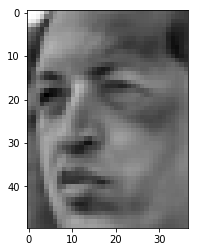

In [17]:
#lets try some rescaling
plt.imshow(StandardScaler().fit_transform(X)[0].reshape((h,w)),cmap=plt.cm.gray)
lfw_people.target_names[y[0]]

In [19]:
# the label to predict is the id of the person
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print ("Total dataset size:")
print ("n_samples: %d" % n_samples)
print ("n_features: %d" % n_features)
print ("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


## Apply Facial Recognition

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state = 7)

In [22]:
#use pca to reduce data - get 200 components
pca = PCA(n_components=200,whiten=True)

#create a pipeline
preprocessing = Pipeline([('scale',StandardScaler()),('pca',pca)])

#fit the pipeline
preprocessing.fit(X_train)

#grab the pca for analysis
extracted_pca = preprocessing.steps[1][1]

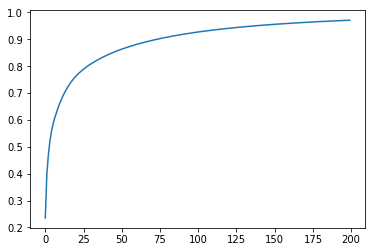

In [24]:
#lets look at the scree plot
plt.plot(np.cumsum(extracted_pca.explained_variance_ratio_));

First 100 components capture over 90% of the variance - compared to the 1850 original features

In [56]:
extracted_pca.components_.shape
comp[0]

array([-0.00874715, -0.00881027, -0.00973822, ..., -0.00273656,
       -0.00230205, -0.00150818], dtype=float32)

In [28]:
#plot the pca components
comp = extracted_pca.components_
image_shape = (h,w)
def plot_gallery(title,images,n_col,n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
        vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()

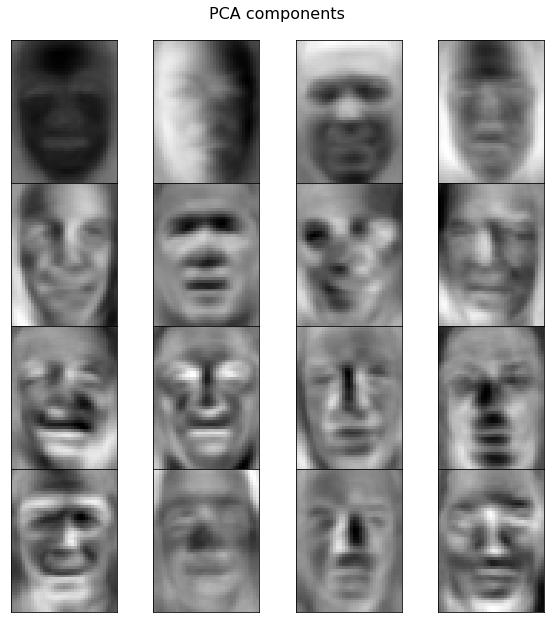

In [29]:
plot_gallery('PCA components', comp[:16], 4,4)

Shows PCA components for a specific row and column.  These eigen-faces are
extracted features of humans that the PCA module is finding. Each of these
components is meant to house vital information about faces that can be used to distinguish
between different people.

The eigen-face in the first row, fourth column seems to be showing a contrast
between the background and the face, putting a number to the lighting situation
of the image.

Eigen-face last row, first column seems to be picking up info on eyes, nose and chin

## Accuracy with confusion matrix

In [30]:
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
#try without PCA
t0 = time()
param_grid = {'C': [1e-2, 1e-1,1e0,1e1, 1e2]}

logreg = LogisticRegression()

clf = GridSearchCV(logreg, param_grid)
clf = clf.fit(X_train, y_train)
best_clf = clf.best_estimator_


In [33]:
# Predicting people's names on the test set
y_pred = best_clf.predict(X_test)

In [34]:
best_clf

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
print (accuracy_score(y_pred, y_test), "Accuracy score for best estimator")
print(classification_report(y_test, y_pred, target_names=target_names))


0.8291925465838509 Accuracy score for best estimator
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.82      0.78        11
     Colin Powell       0.93      0.86      0.89        64
  Donald Rumsfeld       0.67      0.69      0.68        26
    George W Bush       0.87      0.90      0.89       133
Gerhard Schroeder       0.73      0.79      0.76        28
      Hugo Chavez       0.89      0.76      0.82        21
       Tony Blair       0.71      0.69      0.70        39

      avg / total       0.83      0.83      0.83       322



None


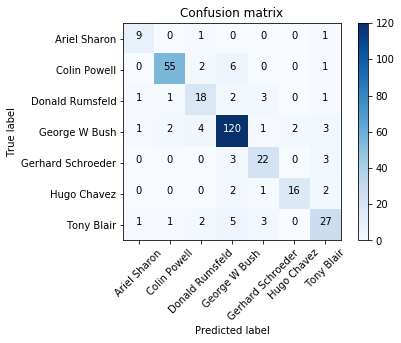

In [39]:
print(plot_confusion_matrix(confusion_matrix(y_test, y_pred,labels=range(n_classes)), target_names))
#print( round((time() - t0), 1), "seconds to grid search and predict the test set")

In [40]:
confusion_matrix(y_test, y_pred,labels=range(n_classes))

array([[  9,   0,   1,   0,   0,   0,   1],
       [  0,  55,   2,   6,   0,   0,   1],
       [  1,   1,  18,   2,   3,   0,   1],
       [  1,   2,   4, 120,   1,   2,   3],
       [  0,   0,   0,   3,  22,   0,   3],
       [  0,   0,   0,   2,   1,  16,   2],
       [  1,   1,   2,   5,   3,   0,  27]], dtype=int64)

lets try same with PCA components = 200

0.7608695652173914 Accuracy score for best estimator
                   precision    recall  f1-score   support

     Ariel Sharon       0.46      0.55      0.50        11
     Colin Powell       0.85      0.72      0.78        64
  Donald Rumsfeld       0.64      0.62      0.63        26
    George W Bush       0.83      0.86      0.85       133
Gerhard Schroeder       0.60      0.75      0.67        28
      Hugo Chavez       0.78      0.67      0.72        21
       Tony Blair       0.71      0.69      0.70        39

      avg / total       0.77      0.76      0.76       322

None


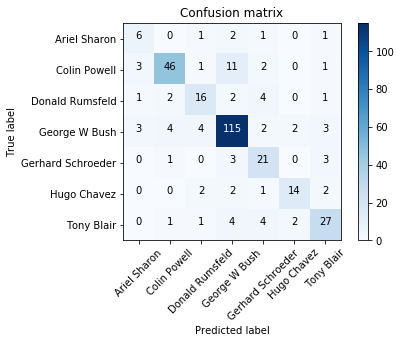

In [42]:
face_pipeline = Pipeline(steps=[('PCA', PCA(n_components=200)),('logistic', logreg)])
pipe_param_grid = {'logistic__C': [1e-2, 1e-1,1e0,1e1, 1e2]}
clf = GridSearchCV(face_pipeline, pipe_param_grid)
clf = clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# Predicting people's names on the test set
y_pred = best_clf.predict(X_test)
print(accuracy_score(y_pred, y_test), "Accuracy score for best estimator")
print(classification_report(y_test, y_pred, target_names=target_names))
print(plot_confusion_matrix(confusion_matrix(y_test, y_pred,labels=range(n_classes)), target_names))
#print round((time() - t0), 1), "seconds to grid search and predict the test set"

Accuracy has dropped from 83 to 76 percent

## Apply Larger Pipeline


In [60]:
#test function
def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model, # the model to grid search
            params, # the parameter set to try
            error_score=0.) # if a parameter set raises an error, continue and set the performance 0
    grid.fit(X, y) # fit the model and parameters
    # our classical metric for performance
    print("Best Accuracy: {}".format(grid.best_score_))
    # the best parameters that caused the best accuracy
    print("Best Parameters: {}".format(grid.best_params_))
    # the average time it took a model to fit to the data (in seconds)
    print("Average Time to Fit (s):{}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    print( "Average Time to Score (s):{}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))


- A scaling module
- A PCA module to extract the best features that capture the variance in the data
- A Linear Discriminat Analysis (LDA) module to create features that best separate the faces from one another
- Linear classifier, which will reap the benefits of our three feature engineering modules and attempt to distinguish between our faces

In [61]:
# Create a larger pipeline to gridsearch
face_params = {'logistic__C':[1e-2, 1e-1, 1e0, 1e1, 1e2],'preprocessing__pca__n_components':[100, 150, 200, 250,300],
 'preprocessing__pca__whiten':[True, False],
 'preprocessing__lda__n_components':range(1, 7)
 # [1, 2, 3, 4, 5, 6] recall the max allowed is n_classes-1
 }
pca = PCA()
lda = LinearDiscriminantAnalysis()
preprocessing = Pipeline([('scale', StandardScaler()), ('pca', pca),('lda', lda)])
logreg = LogisticRegression()
face_pipeline = Pipeline(steps=[('preprocessing', preprocessing),('logistic', logreg)])
get_best_model_and_accuracy(face_pipeline, face_params, X, y)


Best Accuracy: 0.843944099378882
Best Parameters: {'logistic__C': 100.0, 'preprocessing__lda__n_components': 6, 'preprocessing__pca__n_components': 150, 'preprocessing__pca__whiten': False}
Average Time to Fit (s):0.104
Average Time to Score (s):0.008


Accuracy of 84% with 150 pca components and LDA